# Proximal Policy Optimization (PPO)

Como vimos na aula de A2C, uma função objetivo muito utilizada é:

$$
    J(\theta) =  \mathbb{E}_{s,a\sim\pi_\theta} [A^{\pi_\theta}_w(s,a)], \qquad
    \nabla_\theta J(\theta) =  \mathbb{E}_{s,a\sim\pi_\theta} [\nabla_\theta \log \pi_\theta(a|s)\cdot A^{\pi_\theta}_w(s,a)].
$$

Os índices na função _advantage_ $A$ indicam que $A$ depende tanto dos pesos $w$ utilizados para calcular o estimar de cada estado, quanto da política $\pi_\theta$, que determina quais trajetórias o agente vai seguir dentro do ambiente.

> Obs: pode-se mostrar que essa formulação é equivalente à formulação que utiliza somatórias no tempo:
$$
    J(\theta) =  \mathbb{E}_{(s_0,a_0,\dots)\sim\pi_\theta} \left[\sum_{t=0}^\infty \gamma^t A^{\pi_\theta}_w(s_t,a_t)\right], \qquad
    \nabla_\theta J(\theta) =  \mathbb{E}_{(s_0,a_0,\dots)\sim\pi_\theta} \left[\sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t|s_t)\cdot A^{\pi_\theta}_w(s_t,a_t)\right].
$$

Note que uma pequena variação no espaço de parâmetros ($\Delta\theta = \alpha\nabla_\theta J$) pode causar uma grande variação no espaço de políticas. Isso significa que, em geral, a taxa de aprendizado $\alpha$ não pode ser muito alta; caso contrário, corremos o risco de obter uma nova política que não funcione. Consequentemente, a eficiência amostral de A2C também é limitada.


## Trust Region Policy Optimization (TRPO)

Uma maneira de resolver esse problema é limitar as variações na política. Para isso, vamos utilizar a divergência KL $KL(\pi_1 || \pi_2)$, que pode ser, simplificadamente, encarada como uma medida da diferença entre duas políticas (ou, em geral, duas distribuições de probabilidade).

TRPO define uma região de confiança (trust region) para garantir que a política nova não se distancie demais da política antiga:
$$E_{s\sim\pi_{\theta_{\mathrm{old}}}}\bigl[KL\bigl(\pi_{\mathrm{old}}(\cdot|s)\,||\,\pi(\cdot|s)\bigr)\bigr] \le \delta.$$

No entanto, maximizar a função objetivo de A2C sujeito a essas restrições é um pouco complicado. Então, vamos utilizar uma aproximação da função objetivo de A2C:

$$L(\theta_{\mathrm{old}},\theta) = E_{s,a\sim\pi_{\theta_{\mathrm{old}}}} \left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{\mathrm{old}}}(a|s)} A^{\pi_{\theta_{\mathrm{old}}}}(s,a)\right].$$

Ou seja, TRPO consiste em:
$$\text{maximizar } E_{s,a\sim\pi_{\theta_{\mathrm{old}}}} \left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{\mathrm{old}}}(a|s)} A^{\pi_{\theta_{\mathrm{old}}}}(s,a)\right] \text{ sujeito a } E_{s\sim\pi_{\theta_{\mathrm{old}}}}\bigl[KL\bigl(\pi_{\mathrm{old}}(\cdot|s)\,||\,\pi(\cdot|s)\bigr)\bigr] \le \delta.$$

> Para entender como chegamos $L(\theta_{\mathrm{old}},\theta)$ é uma aproximação de $J(\theta)$, podemos fazer:
\begin{align*}
J(\theta) &= E_{\pi_\theta}[A^{\pi_\theta}(s,a)] \\
        &= E_{\pi_\theta}[A^{\pi_{\theta_{\mathrm{old}}}}(s,a)] \\
		&= \sum_{s,a} \rho_{\pi_\theta}(s)\cdot \pi_\theta(a|s) \cdot A^{\pi_{\theta_{\mathrm{old}}}}(s,a) \\
		&= \sum_{s,a} \rho_{\pi_\theta}(s)\cdot \pi_{\theta_{\mathrm{old}}}(a|s) \cdot \frac{\pi_\theta(a|s)}{\pi_{\theta_{\mathrm{old}}}(a|s)}A^{\pi_{\theta_{\mathrm{old}}}}(s,a) \\
		&\approx \sum_{s,a} \rho_{\pi_{\theta_{\mathrm{old}}}}(s)\cdot \pi_{\theta_{\mathrm{old}}}(a|s) \cdot \frac{\pi_\theta(a|s)}{\pi_{\theta_{\mathrm{old}}}(a|s)}A^{\pi_{\theta_{\mathrm{old}}}}(s,a) \\
		&= E_{\pi_{\theta_{\mathrm{old}}}} \left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{\mathrm{old}}}(a|s)} A^{\pi_\theta}(s,a)\right]
\end{align*}


## Proximal Policy Optimization (PPO)

Como já foi mencionado, a restrição ($KL < \delta$) imposta em TRPO torna o algoritmo relativamente complicado. PPO é uma tentativa de simplificar esse algoritmo. Ao invés de utilizar trust regions, PPO mexe diretamente com a função objetivo:

$$
    L(\theta_{\mathrm{old}},\theta) = E_{s,a\sim\pi_{\theta_{\mathrm{old}}}} \Bigl[\min\left(r A^{\pi_{\theta_{\mathrm{old}}}}(s,a),\, \operatorname{clip}(r,1-\varepsilon,1+\varepsilon) A^{\pi_{\theta_{\mathrm{old}}}}(s,a)\right)\Bigr],
    \quad
    r = \frac{\pi_\theta(a|s)}{\pi_{\theta_{\mathrm{old}}}(a|s)}.
$$
Essa função pode ser reescrita como:
$$
    L(\theta_{\mathrm{old}},\theta) = E_{s,a\sim\pi_{\theta_{\mathrm{old}}}} \Bigl[\min\left(r A^{\pi_{\theta_{\mathrm{old}}}}(s,a),\, g(\varepsilon, A^{\pi_{\theta_{\mathrm{old}}}}(s,a))\right)\Bigr],
    \quad
    g(\varepsilon, A) = \begin{cases}
        (1+\varepsilon) A, & A \ge 0 \\
        (1-\varepsilon) A,  & A < 0.
    \end{cases}
$$

Nota-se que:
- Quando a vantagem é positiva, se $r$ aumentar, então $L$ aumenta. No entanto, esse benefício é limitado pelo clip: se $r > 1+\varepsilon$, não há mais benefício para $r$ aumentar.
- Quando a vantagem é negativa, se $r$ diminuir, então $L$ aumenta. No entanto, esse benefício é limitado pelo clip: se $r < 1-\varepsilon$, não há mais benefício para $r$ diminuir.

A seguinte imagem pode te ajudar a visualizar o clip. Note que todos os valores fora do clip estipulado estão constantes:

![imagem ilustrando o clip](imgs/clip.png)


## Rede Divida

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
class ActorCritic(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super(ActorCritic, self).__init__()
        self.policy1 = nn.Linear(observation_shape, 64)
        self.policy2 = nn.Linear(64, 64)
        self.policy3 = nn.Linear(64, action_shape)
        
        self.value1 = nn.Linear(observation_shape, 64)
        self.value2 = nn.Linear(64, 64)
        self.value3 = nn.Linear(64, 1)

    def forward(self, state):
        dists = torch.relu(self.policy1(state))
        dists = torch.relu(self.policy2(dists))
        dists = F.softmax(self.policy3(dists), dim=-1)
        probs = Categorical(dists)
        
        v = torch.relu(self.value1(state))
        v = torch.relu(self.value2(v))
        v = self.value3(v)

        return probs, v

## Memory Buffer

In [2]:
import numpy as np

class MemoryBuffer:
    """Memory Buffer para PPO."""
    def __init__(self, max_length, observation_space):
        """Cria um Memory Buffer.

        Parâmetros
        ----------
        max_length: int
            Tamanho máximo do Memory Buffer.
        observation_space: int
            Tamanho do espaço de observação.
        """
        self.length = 0
        self.max_length = max_length

        self.states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.actions = np.zeros((max_length), dtype=np.int32)
        self.rewards = np.zeros((max_length), dtype=np.float32)
        self.next_states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.dones = np.zeros((max_length), dtype=np.float32)
        self.logp = np.zeros((max_length), dtype=np.float32)

    def update(self, states, actions, rewards, next_states, dones, logp):
        """Adiciona uma experiência ao Memory Buffer.

        Parâmetros
        ----------
        state: np.array
            Estado da transição.
        action: int
            Ação tomada.
        reward: float
            Recompensa recebida.
        state: np.array
            Estado seguinte.
        done: int
            Flag indicando se o episódio acabou.
        logp: float
            Log da probabildiade de acordo com a política.
        """
        self.states[self.length] = states
        self.actions[self.length] = actions
        self.rewards[self.length] = rewards
        self.next_states[self.length] = next_states
        self.dones[self.length] = dones
        self.logp[self.length] = logp
        self.length += 1

    def get_batch(self):
        """Retorna um batch de experiências.
        
        Parâmetros
        ----------
        batch_size: int
            Tamanho do batch de experiências.

        Retorna
        -------
        states: np.array
            Batch de estados.
        actions: np.array
            Batch de ações.
        rewards: np.array
            Batch de recompensas.
        next_states: np.array
            Batch de estados seguintes.
        dones: np.array
            Batch de flags indicando se o episódio acabou.
        logp: np.array
            Batch do log da probabildiade de acordo com a política.
        """
        self.length = 0

        return (self.states, self.actions, self.rewards, self.next_states, self.dones, self.logp)

In [4]:
import torch
import torch.optim as optim

class PPO:
    def __init__(self, observation_space, action_space, lr=7e-4, gamma=0.99, lam=0.95, vf_coef=0.5, entropy_coef=0.005,clip_param =0.2, epochs =10, memory_len=16):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.lam = lam
        self.vf_coef = vf_coef
        self.entropy_coef = entropy_coef
        self.clip_param = clip_param
        self.epochs = epochs

        self.memory_len = memory_len
        self.memory = MemoryBuffer(memory_len, observation_space.shape[0])

        self.actorcritic = ActorCritic(observation_space.shape[0], action_space.n).to(self.device)
        self.actorcritic_optimizer = optim.Adam(self.actorcritic.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        probs, v = self.actorcritic.forward(state)
        action = probs.sample()
        log_prob = probs.log_prob(action)
        return action.cpu().detach().item(), log_prob.detach().cpu().numpy()

    def remember(self, state, action, reward, next_state, done, logp):
        self.memory.update(state, action, reward, next_state, done, logp)

    def compute_gae(self, rewards, dones, v, v2):
        T = len(rewards)

        returns = torch.zeros_like(rewards)
        gaes = torch.zeros_like(rewards)
        
        future_gae = torch.tensor(0.0, dtype=rewards.dtype)
        next_return = torch.tensor(v2[-1], dtype=rewards.dtype)

        not_dones = 1 - dones
        deltas = rewards + not_dones * self.gamma * v2 - v

        for t in reversed(range(T)):
            returns[t] = next_return = rewards[t] + self.gamma * not_dones[t] * next_return
            gaes[t] = future_gae = deltas[t] + self.gamma * self.lam * not_dones[t] * future_gae

        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8) # Normalização

        return gaes, returns

    def train(self):
        if self.memory.length < self.memory_len:
            return

        (states, actions, rewards, next_states, dones, old_logp) = self.memory.get_batch()

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(-1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(-1).to(self.device)
        old_logp = torch.FloatTensor(old_logp).to(self.device)
        
        with torch.no_grad():
            _, v = self.actorcritic.forward(states)
            _, v2 = self.actorcritic.forward(next_states)
        
        advantages, returns = self.compute_gae(rewards, dones, v, v2)
        
        for epoch in range(self.epochs):
            
            probs, v = self.actorcritic.forward(states)

            new_logp = probs.log_prob(actions)

            #Equações principais do algoritmo
            ratio = (new_logp.unsqueeze(-1) - old_logp.unsqueeze(-1)).exp() 
            surr1 = ratio * advantages.detach()
            surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantages.detach()

            entropy = probs.entropy().mean()

            policy_loss =   - torch.min(surr1,surr2).mean()
            value_loss =    self.vf_coef * F.mse_loss(v, returns.detach())
            entropy_loss = -self.entropy_coef * entropy

            self.actorcritic_optimizer.zero_grad()
            (policy_loss + entropy_loss + value_loss).backward()
            self.actorcritic_optimizer.step()

        return policy_loss + entropy_loss + value_loss

## Treinando

In [5]:
import math
from collections import deque

def train(agent, env, total_timesteps):
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []

    state = env.reset()
    timestep = 0
    episode = 0

    while timestep < total_timesteps:
        action, log_prob = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done, log_prob)
        loss = agent.train()
        timestep += 1

        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()

        if episode_returns:
            avg_returns.append(np.mean(episode_returns))

        total_reward *= 1 - done
        state = next_state

        ratio = math.ceil(100 * timestep / total_timesteps)

        avg_return = avg_returns[-1] if avg_returns else np.nan
        
        print(f"\r[{ratio:3d}%] timestep = {timestep}/{total_timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}", end="")

    return avg_returns

In [6]:
import gym

env = gym.make("CartPole-v1")
agente = PPO(env.observation_space, env.action_space)
returns = train(agente, env, 75000)

[100%] timestep = 75000/75000, episode = 295, avg_return =   256.9000

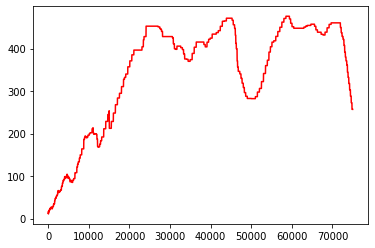

In [7]:
import matplotlib.pyplot as plt

plt.plot(returns, 'r')
plt.show()

O agente demonstra consegue solocuinar o ambiente. Porém acaba desaprendendo, para solucionar isso é possível fazer uma otimização nos hiper-parâmetros. É possível também implementar algum tipo de parada antecipada.